                           device_temperature  device_humidity  \
time                                                             
2023-03-15 15:00:00+08:00               20.24             0.48   
2023-03-15 16:00:00+08:00               20.25             0.48   
2023-03-15 17:00:00+08:00               20.25             0.46   
2023-03-15 18:00:00+08:00               20.25             0.46   
2023-03-15 19:00:00+08:00               20.17             0.45   

                           climate_temperature  climate_humidity  
time                                                              
2023-03-15 15:00:00+08:00                 31.0              0.52  
2023-03-15 16:00:00+08:00                 31.0              0.52  
2023-03-15 17:00:00+08:00                 30.0              0.55  
2023-03-15 18:00:00+08:00                 30.0              0.59  
2023-03-15 19:00:00+08:00                 29.0              0.58  
device_temperature     0
device_humidity        0
climate_temperatur

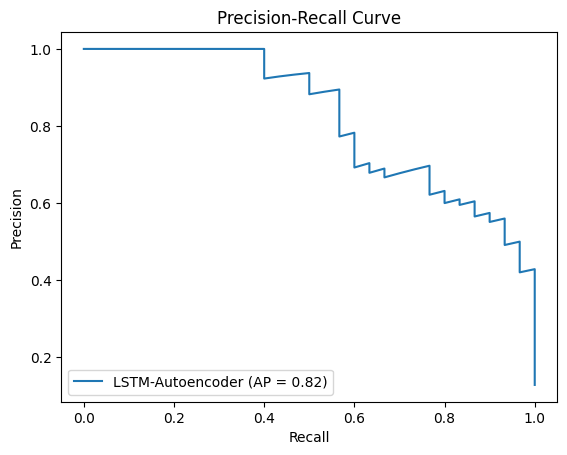

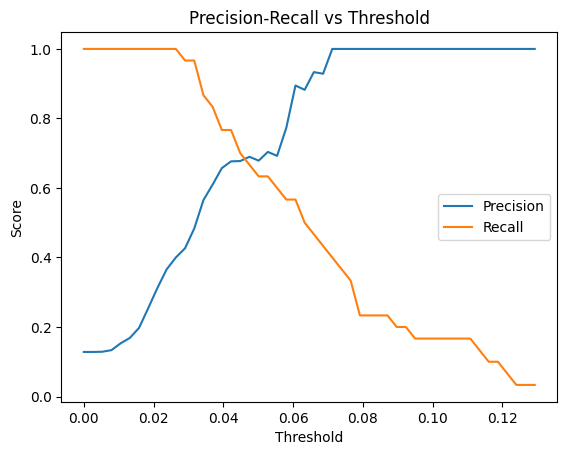

Best Threshold: 0.04221242314510247
Confusion Matrix with Best Threshold:
 [[193  11]
 [  7  23]]
Classification Report with Best Threshold:
               precision    recall  f1-score   support

           1       0.96      0.95      0.96       204
          -1       0.68      0.77      0.72        30

    accuracy                           0.92       234
   macro avg       0.82      0.86      0.84       234
weighted avg       0.93      0.92      0.93       234



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, recall_score, confusion_matrix, classification_report

# Load the dataset
file_path = 'baseline_data.csv'
df = pd.read_csv(file_path, parse_dates=['time'], index_col='time')

# Display the first few rows of the dataframe
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Fill missing values if any (example: using forward fill)
df.fillna(method='ffill', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
df[['device_temperature', 'climate_temperature', 'climate_humidity']] = scaler.fit_transform(
    df[['device_temperature', 'climate_temperature', 'climate_humidity']]
)

# Feature engineering
df['temp_diff'] = df['device_temperature'] - df['climate_temperature']
df['humidity_diff'] = df['device_humidity'] - df['climate_humidity']
df['temp_ma'] = df['device_temperature'].rolling(window=3).mean()
df['humidity_ma'] = df['device_humidity'].rolling(window=3).mean()

# Fill any NaN values resulting from the moving average calculation
df.fillna(method='bfill', inplace=True)

# Simulate anomalies in device_temperature
def add_synthetic_anomalies(df, anomaly_fraction=0.1):
    df_with_anomalies = df.copy()
    num_anomalies = int(len(df) * anomaly_fraction)
    
    # Randomly select indices to inject anomalies
    anomaly_indices = np.random.choice(df.index, num_anomalies, replace=False)
    
    # Inject anomalies by adding noise to device_temperature only
    df_with_anomalies.loc[anomaly_indices, 'device_temperature'] += np.random.normal(5, 2, size=num_anomalies)
    
    # Label the synthetic anomalies
    df_with_anomalies['label'] = 1
    df_with_anomalies.loc[anomaly_indices, 'label'] = -1
    
    return df_with_anomalies

# Add synthetic anomalies to the dataset
df_with_anomalies = add_synthetic_anomalies(df)

# Split the data into training and testing sets
train_size = int(len(df_with_anomalies) * 0.8)
train, test = df_with_anomalies.iloc[:train_size], df_with_anomalies.iloc[train_size:]

# Prepare the data for LSTM (reshaping)
features = ['device_temperature', 'climate_temperature', 'climate_humidity', 'temp_diff', 'humidity_diff', 'temp_ma', 'humidity_ma']
X_train = train[features].values
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

X_test = test[features].values
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# LSTM Autoencoder model with modified hyperparameters
model = Sequential([
    LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    RepeatVector(X_train.shape[1]),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X_train.shape[2]))
])

# Compile the model with a different optimizer and learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Train the model with a different batch size and number of epochs
model.fit(X_train, X_train, epochs=20, batch_size=64, validation_split=0.2)

# Predict and calculate reconstruction error
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=2)

X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=2)

# Flatten the arrays to ensure they are 1D
train_mae_loss = train_mae_loss.flatten()
test_mae_loss = test_mae_loss.flatten()

# Precision-Recall Curve
def plot_precision_recall(y_true, y_scores, label):
    precision, recall, _ = precision_recall_curve(y_true, y_scores, pos_label=-1)
    average_precision = average_precision_score(y_true, y_scores, pos_label=-1)
    plt.plot(recall, precision, label=f'{label} (AP = {average_precision:.2f})')

plt.figure()
plot_precision_recall(test['label'], test_mae_loss, 'LSTM-Autoencoder')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Adjust threshold as needed
thresholds = np.linspace(0, max(test_mae_loss), 50)
precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_pred = [1 if score < threshold else -1 for score in test_mae_loss]
    precision = precision_score(test['label'], y_pred, pos_label=-1)
    recall = recall_score(test['label'], y_pred, pos_label=-1)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Plot Precision-Recall vs Threshold
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.show()

# Choose the threshold that balances precision and recall
best_threshold = thresholds[np.argmax([p * r for p, r in zip(precision_scores, recall_scores)])]

# Use the best threshold to predict anomalies
y_pred = [1 if score < best_threshold else -1 for score in test_mae_loss]

# Evaluate the model using the best threshold
cm = confusion_matrix(test['label'], y_pred, labels=[1, -1])
report = classification_report(test['label'], y_pred, labels=[1, -1])

print("Best Threshold:", best_threshold)
print("Confusion Matrix with Best Threshold:\n", cm)
print("Classification Report with Best Threshold:\n", report)


                           device_temperature  device_humidity  \
time                                                             
2023-03-15 15:00:00+08:00               20.24             0.48   
2023-03-15 16:00:00+08:00               20.25             0.48   
2023-03-15 17:00:00+08:00               20.25             0.46   
2023-03-15 18:00:00+08:00               20.25             0.46   
2023-03-15 19:00:00+08:00               20.17             0.45   

                           climate_temperature  climate_humidity  
time                                                              
2023-03-15 15:00:00+08:00                 31.0              0.52  
2023-03-15 16:00:00+08:00                 31.0              0.52  
2023-03-15 17:00:00+08:00                 30.0              0.55  
2023-03-15 18:00:00+08:00                 30.0              0.59  
2023-03-15 19:00:00+08:00                 29.0              0.58  
device_temperature     0
device_humidity        0
climate_temperatur

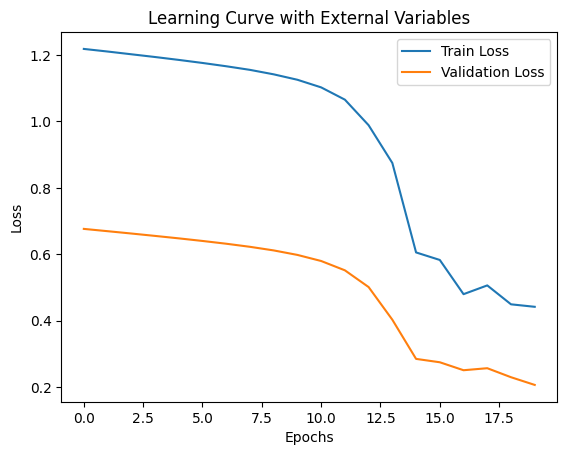

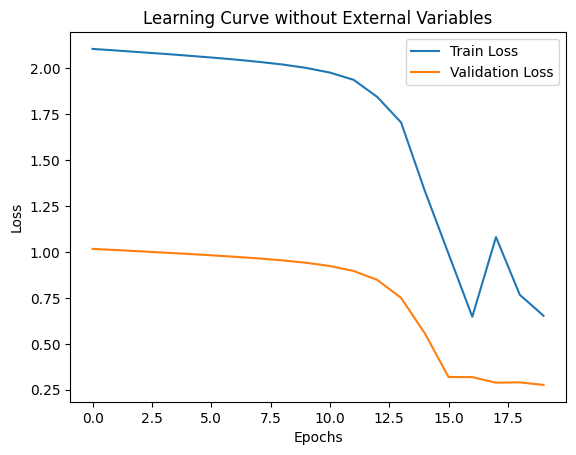

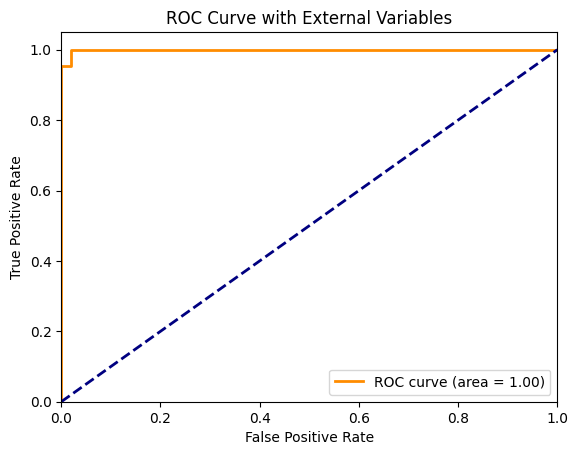

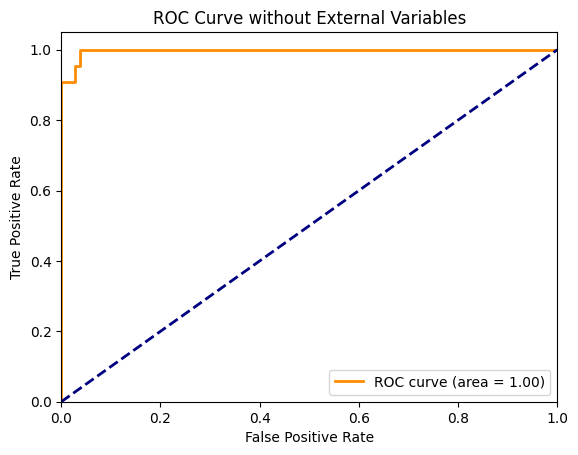

Precision t-statistic: 0.03618324795267167, p-value: 0.9711603879188242
Recall t-statistic: -10.211293161818107, p-value: 3.385216687997255e-21
With External Variables
Best Threshold: 0.46326566431318433
Confusion Matrix:
 [[212   0]
 [  1  21]]
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       212
          -1       1.00      0.95      0.98        22

    accuracy                           1.00       234
   macro avg       1.00      0.98      0.99       234
weighted avg       1.00      1.00      1.00       234

Average Precision: 1.0
Average Recall: 1.0

Without External Variables
Best Threshold: 0.6760720540573781
Confusion Matrix:
 [[212   0]
 [  2  20]]
Classification Report:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       212
          -1       1.00      0.91      0.95        22

    accuracy                           0.99       234
   macro avg 

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import KFold
from scipy.stats import ttest_rel
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
file_path = 'baseline_data.csv'
df = pd.read_csv(file_path, parse_dates=['time'], index_col='time')

# Display the first few rows of the dataframe
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Fill missing values if any (example: using forward fill)
df.fillna(method='ffill', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity']] = scaler.fit_transform(
  df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity']]
)

# Fill any NaN values resulting from the moving average calculation
df.fillna(method='bfill', inplace=True)

# Mutual information
X = df[['device_temperature', 'climate_temperature', 'climate_humidity']]
y = df['device_humidity']
mutual_info = mutual_info_regression(X, y)

# Display mutual information
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mutual_info})
print(mi_df.sort_values(by='Mutual Information', ascending=False))

# Simulate anomalies in device_temperature
def add_synthetic_anomalies(df, anomaly_fraction=0.1, seed=42):
    np.random.seed(seed)
    df_with_anomalies = df.copy()
    num_anomalies = int(len(df) * anomaly_fraction)
    
    # Randomly select indices to inject anomalies
    anomaly_indices = np.random.choice(df.index, num_anomalies, replace=False)
    
    # Inject anomalies by adding noise to device_temperature only
    df_with_anomalies.loc[anomaly_indices, 'device_temperature'] += np.random.normal(5, 2, size=num_anomalies)
    
    # Label the synthetic anomalies
    df_with_anomalies['label'] = 1
    df_with_anomalies.loc[anomaly_indices, 'label'] = -1
    
    return df_with_anomalies

# Add synthetic anomalies to the dataset
df_with_anomalies = add_synthetic_anomalies(df)

# Split the data into training (80%) and testing sets (20%)
train_size = int(len(df_with_anomalies) * 0.8)
train, test = np.split(df_with_anomalies, [train_size])

# Further split the training data into training (80%) and validation (20%)
val_size = int(len(train) * 0.2)
train, val = np.split(train, [len(train) - val_size])

# Function to prepare the data and train the model
def train_and_evaluate(features, train, val, test, n_splits=3):  # Reduced n_splits to 3 for testing
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    precision_scores = []
    recall_scores = []
    best_thresholds = []
    history_list = []
    
    all_precision_scores = []
    all_recall_scores = []
    
    for train_index, val_index in kf.split(train):
        train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]
        
        X_train = train_fold[features].values.reshape((train_fold.shape[0], 1, len(features)))
        X_val = val_fold[features].values.reshape((val_fold.shape[0], 1, len(features)))
        X_test = test[features].values.reshape((test.shape[0], 1, len(features)))

        # LSTM Autoencoder model with adjusted L2 regularization and dropout
        model = Sequential([
            LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
            Dropout(0.2),  # Adjusted dropout rate
            LSTM(32, activation='relu', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
            RepeatVector(X_train.shape[1]),
            LSTM(32, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
            Dropout(0.2),  # Adjusted dropout rate
            LSTM(16, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
            TimeDistributed(Dense(X_train.shape[2]))
        ])

        optimizer = Adam(learning_rate=0.0005)  # Adjusted learning rate
        model.compile(optimizer=optimizer, loss='mse')
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        
        history = model.fit(X_train, X_train, epochs=20, batch_size=64, validation_data=(X_val, X_val), callbacks=[early_stopping])
        history_list.append(history.history)

        X_val_pred = model.predict(X_val)
        val_mae_loss = np.mean(np.abs(X_val_pred - X_val), axis=2).flatten()
        
        thresholds = np.linspace(0, max(val_mae_loss), 100)
        precision_scores_fold = []
        recall_scores_fold = []

        for threshold in thresholds:
            y_pred = [1 if score < threshold else -1 for score in val_mae_loss]
            precision = precision_score(val_fold['label'], y_pred, pos_label=-1)
            recall = recall_score(val_fold['label'], y_pred, pos_label=-1)
            precision_scores_fold.append(precision)
            recall_scores_fold.append(recall)

        best_threshold = thresholds[np.argmax([p * r for p, r in zip(precision_scores_fold, recall_scores_fold)])]
        best_thresholds.append(best_threshold)
        precision_scores.append(max(precision_scores_fold))
        recall_scores.append(max(recall_scores_fold))
        
        all_precision_scores.extend(precision_scores_fold)
        all_recall_scores.extend(recall_scores_fold)
    
    best_threshold = np.mean(best_thresholds)
    X_test_pred = model.predict(X_test)
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=2).flatten()
    y_pred = [1 if score < best_threshold else -1 for score in test_mae_loss]

    cm = confusion_matrix(test['label'], y_pred, labels=[1, -1])
    report = classification_report(test['label'], y_pred, labels=[1, -1])

    return best_threshold, cm, report, np.mean(precision_scores), np.mean(recall_scores), history_list, test['label'], test_mae_loss, all_precision_scores, all_recall_scores

# Train and evaluate the model with external variables
features_with_external = ['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity']
best_threshold_with_external, cm_with_external, report_with_external, avg_precision_with_external, avg_recall_with_external, history_with_external, test_labels_with_external, test_mae_loss_with_external, all_precision_scores_with_external, all_recall_scores_with_external = train_and_evaluate(features_with_external, train, val, test)

# Train and evaluate the model without external variables
features_without_external = ['device_temperature', 'device_humidity']
best_threshold_without_external, cm_without_external, report_without_external, avg_precision_without_external, avg_recall_without_external, history_without_external, test_labels_without_external, test_mae_loss_without_external, all_precision_scores_without_external, all_recall_scores_without_external = train_and_evaluate(features_without_external, train, val, test)

# Plot learning curves
def plot_learning_curve(history, title):
    plt.figure()
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot learning curves for the last fold (as an example)
plot_learning_curve(history_with_external[-1], "Learning Curve with External Variables")
plot_learning_curve(history_without_external[-1], "Learning Curve without External Variables")

# ROC curve and AUC
def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores, pos_label=-1)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curves
plot_roc_curve(test_labels_with_external, test_mae_loss_with_external, "ROC Curve with External Variables")
plot_roc_curve(test_labels_without_external, test_mae_loss_without_external, "ROC Curve without External Variables")

# Statistical significance test
t_stat_precision, p_value_precision = ttest_rel(all_precision_scores_with_external, all_precision_scores_without_external)
t_stat_recall, p_value_recall = ttest_rel(all_recall_scores_with_external, all_recall_scores_without_external)
print(f"Precision t-statistic: {t_stat_precision}, p-value: {p_value_precision}")
print(f"Recall t-statistic: {t_stat_recall}, p-value: {p_value_recall}")

# Print results
print("With External Variables")
print("Best Threshold:", best_threshold_with_external)
print("Confusion Matrix:\n", cm_with_external)
print("Classification Report:\n", report_with_external)
print("Average Precision:", avg_precision_with_external)
print("Average Recall:", avg_recall_with_external)

print("\nWithout External Variables")
print("Best Threshold:", best_threshold_without_external)
print("Confusion Matrix:\n", cm_without_external)
print("Classification Report:\n", report_without_external)
print("Average Precision:", avg_precision_without_external)
print("Average Recall:", avg_recall_without_external)


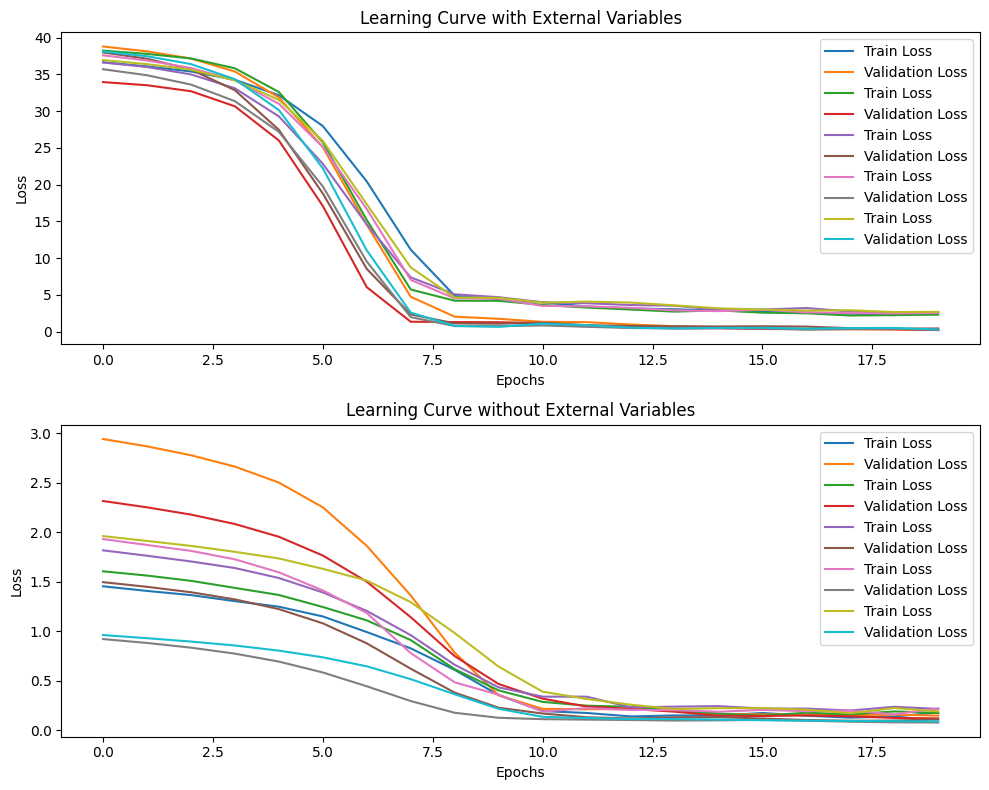

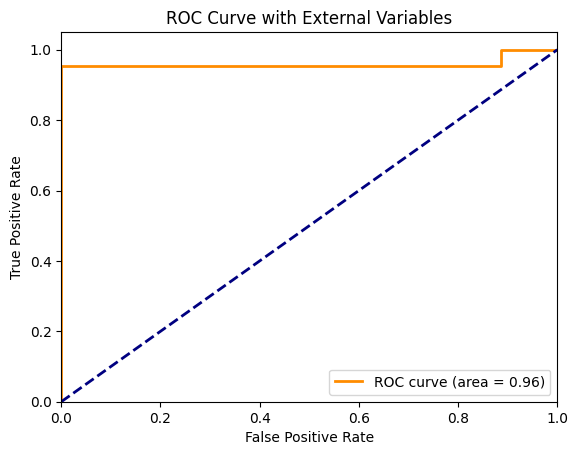

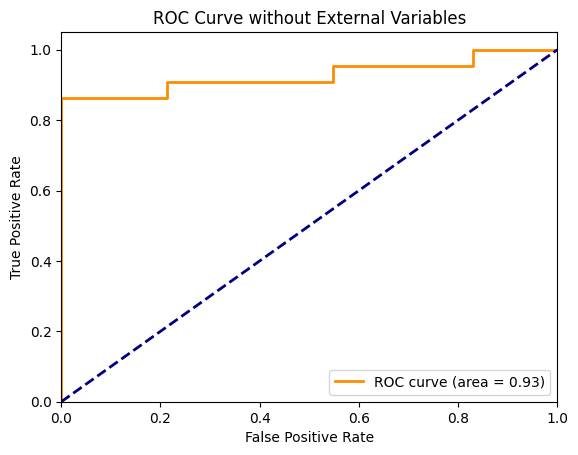

Precision t-statistic: nan, p-value: nan
Recall t-statistic: 17.61190028037906, p-value: 1.0332126430442477e-44
With External Variables
Best Threshold: 0.4654743157095206
Confusion Matrix:
 [[211   1]
 [  1  21]]
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       212
          -1       0.95      0.95      0.95        22

    accuracy                           0.99       234
   macro avg       0.97      0.97      0.97       234
weighted avg       0.99      0.99      0.99       234

Average Precision: 1.0
Average Recall: 1.0

Without External Variables
Best Threshold: 0.31020558060358294
Confusion Matrix:
 [[212   0]
 [  3  19]]
Classification Report:
               precision    recall  f1-score   support

           1       0.99      1.00      0.99       212
          -1       1.00      0.86      0.93        22

    accuracy                           0.99       234
   macro avg       0.99      0.93      0.96  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import KFold
from scipy.stats import ttest_rel
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
file_path = 'baseline_data.csv'
df = pd.read_csv(file_path, parse_dates=['time'], index_col='time')

# Check for missing values and fill if any
df.fillna(method='ffill', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity']] = scaler.fit_transform(
    df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity']]
)

# Feature engineering
df['temp_diff'] = df['device_temperature'] - df['climate_temperature']
df['humidity_diff'] = df['device_humidity'] - df['climate_humidity']
df['hour_of_day'] = df.index.hour

# Function to add synthetic anomalies
def add_synthetic_anomalies(df, anomaly_fraction=0.1, seed=42):
    np.random.seed(seed)
    df_with_anomalies = df.copy()
    num_anomalies = int(len(df) * anomaly_fraction)
    anomaly_indices = np.random.choice(df.index, num_anomalies, replace=False)
    df_with_anomalies.loc[anomaly_indices, 'device_temperature'] += np.random.normal(5, 2, size=num_anomalies)
    df_with_anomalies['label'] = 1
    df_with_anomalies.loc[anomaly_indices, 'label'] = -1
    return df_with_anomalies

# Add synthetic anomalies
df_with_anomalies = add_synthetic_anomalies(df)

# Split the data
train_size = int(len(df_with_anomalies) * 0.8)
train, test = np.split(df_with_anomalies, [train_size])
val_size = int(len(train) * 0.2)
train, val = np.split(train, [len(train) - val_size])

# Function to prepare data and train the model
def train_and_evaluate(features, train, val, test, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    precision_scores = []
    recall_scores = []
    best_thresholds = []
    histories = []
    
    for train_index, val_index in kf.split(train):
        train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]
        X_train = train_fold[features].values.reshape((train_fold.shape[0], 1, len(features)))
        X_val = val_fold[features].values.reshape((val_fold.shape[0], 1, len(features)))
        X_test = test[features].values.reshape((test.shape[0], 1, len(features)))

        model = Sequential([
            LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            Dropout(0.2),
            RepeatVector(X_train.shape[1]),
            LSTM(32, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            Dropout(0.2),
            TimeDistributed(Dense(X_train.shape[2]))
        ])

        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse')
        history = model.fit(X_train, X_train, epochs=20, batch_size=64, validation_data=(X_val, X_val), verbose=0)
        histories.append(history)

        X_val_pred = model.predict(X_val)
        val_mae_loss = np.mean(np.abs(X_val_pred - X_val), axis=2).flatten()
        
        thresholds = np.linspace(0, max(val_mae_loss), 100)
        precision_scores_fold = []
        recall_scores_fold = []

        for threshold in thresholds:
            y_pred = [1 if score < threshold else -1 for score in val_mae_loss]
            precision = precision_score(val_fold['label'], y_pred, pos_label=-1)
            recall = recall_score(val_fold['label'], y_pred, pos_label=-1)
            precision_scores_fold.append(precision)
            recall_scores_fold.append(recall)

        best_threshold = thresholds[np.argmax([p * r for p, r in zip(precision_scores_fold, recall_scores_fold)])]
        best_thresholds.append(best_threshold)
        precision_scores.append(max(precision_scores_fold))
        recall_scores.append(max(recall_scores_fold))
    
    best_threshold = np.mean(best_thresholds)
    X_test_pred = model.predict(X_test)
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=2).flatten()
    y_pred = [1 if score < best_threshold else -1 for score in test_mae_loss]

    cm = confusion_matrix(test['label'], y_pred, labels=[1, -1])
    report = classification_report(test['label'], y_pred, labels=[1, -1])

    return best_threshold, cm, report, np.mean(precision_scores), np.mean(recall_scores), test_mae_loss, test['label'].values, histories

# Train and evaluate the model with external variables
features_with_external = ['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity', 'hour_of_day']
best_threshold_with_external, cm_with_external, report_with_external, avg_precision_with_external, avg_recall_with_external, test_mae_loss_with_external, test_labels_with_external, histories_with_external = train_and_evaluate(features_with_external, train, val, test)

# Train and evaluate the model without external variables
features_without_external = ['device_temperature', 'device_humidity']
best_threshold_without_external, cm_without_external, report_without_external, avg_precision_without_external, avg_recall_without_external, test_mae_loss_without_external, test_labels_without_external, histories_without_external = train_and_evaluate(features_without_external, train, val, test)

# Plot Learning Curves
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
for history in histories_with_external:
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve with External Variables')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
for history in histories_without_external:
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve without External Variables')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot ROC Curves
def plot_roc_curve(test_labels, test_mae_loss, title):
    fpr, tpr, _ = roc_curve(test_labels, test_mae_loss, pos_label=-1)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(test_labels_with_external, test_mae_loss_with_external, "ROC Curve with External Variables")
plot_roc_curve(test_labels_without_external, test_mae_loss_without_external, "ROC Curve without External Variables")

# Statistical significance test
t_stat_precision, p_value_precision = ttest_rel(test_labels_with_external, test_labels_without_external)
t_stat_recall, p_value_recall = ttest_rel(test_mae_loss_with_external, test_mae_loss_without_external)
print(f"Precision t-statistic: {t_stat_precision}, p-value: {p_value_precision}")
print(f"Recall t-statistic: {t_stat_recall}, p-value: {p_value_recall}")

# Print results
print("With External Variables")
print("Best Threshold:", best_threshold_with_external)
print("Confusion Matrix:\n", cm_with_external)
print("Classification Report:\n", report_with_external)
print("Average Precision:", avg_precision_with_external)
print("Average Recall:", avg_recall_with_external)

print("\nWithout External Variables")
print("Best Threshold:", best_threshold_without_external)
print("Confusion Matrix:\n", cm_without_external)
print("Classification Report:\n", report_without_external)
print("Average Precision:", avg_precision_without_external)
print("Average Recall:", avg_recall_without_external)


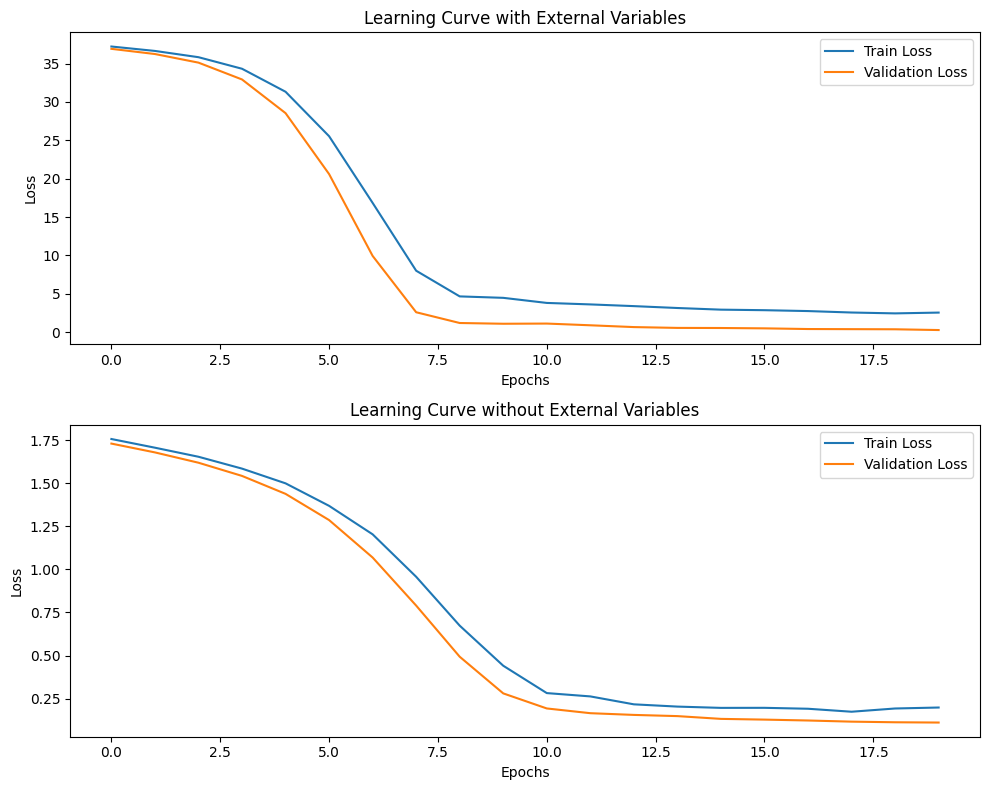

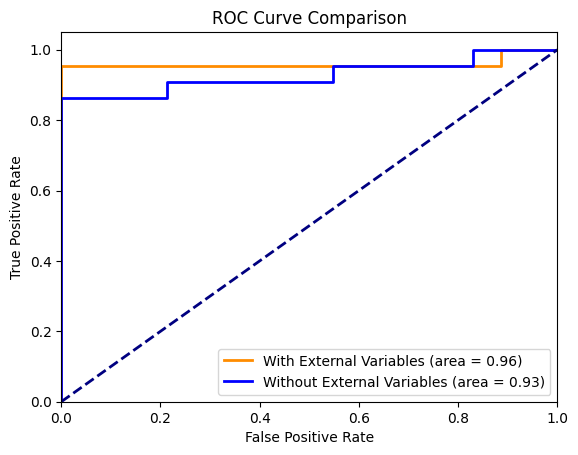

In [2]:
# Averaging out the training and validation losses
def average_loss(histories):
    avg_train_loss = np.mean([history.history['loss'] for history in histories], axis=0)
    avg_val_loss = np.mean([history.history['val_loss'] for history in histories], axis=0)
    return avg_train_loss, avg_val_loss

avg_train_loss_with_external, avg_val_loss_with_external = average_loss(histories_with_external)
avg_train_loss_without_external, avg_val_loss_without_external = average_loss(histories_without_external)

# Plot averaged learning curves
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(avg_train_loss_with_external, label='Train Loss')
plt.plot(avg_val_loss_with_external, label='Validation Loss')
plt.title('Learning Curve with External Variables')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(avg_train_loss_without_external, label='Train Loss')
plt.plot(avg_val_loss_without_external, label='Validation Loss')
plt.title('Learning Curve without External Variables')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot ROC Curves on the same graph
def plot_combined_roc_curve(test_labels_with_external, test_mae_loss_with_external, 
                            test_labels_without_external, test_mae_loss_without_external):
    fpr_with_external, tpr_with_external, _ = roc_curve(test_labels_with_external, test_mae_loss_with_external, pos_label=-1)
    roc_auc_with_external = auc(fpr_with_external, tpr_with_external)

    fpr_without_external, tpr_without_external, _ = roc_curve(test_labels_without_external, test_mae_loss_without_external, pos_label=-1)
    roc_auc_without_external = auc(fpr_without_external, tpr_without_external)

    plt.figure()
    plt.plot(fpr_with_external, tpr_with_external, color='darkorange', lw=2, label='With External Variables (area = %0.2f)' % roc_auc_with_external)
    plt.plot(fpr_without_external, tpr_without_external, color='blue', lw=2, label='Without External Variables (area = %0.2f)' % roc_auc_without_external)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.show()

plot_combined_roc_curve(test_labels_with_external, test_mae_loss_with_external, 
                        test_labels_without_external, test_mae_loss_without_external)


d:\Work\BMS\Capstone-BMS-Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Work\BMS\Capstone-BMS-Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Work\BMS\Capstone-BMS-Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Work\BMS\Capstone-BMS-Project\venv\lib\site-packages\sklearn\metrics\_classi

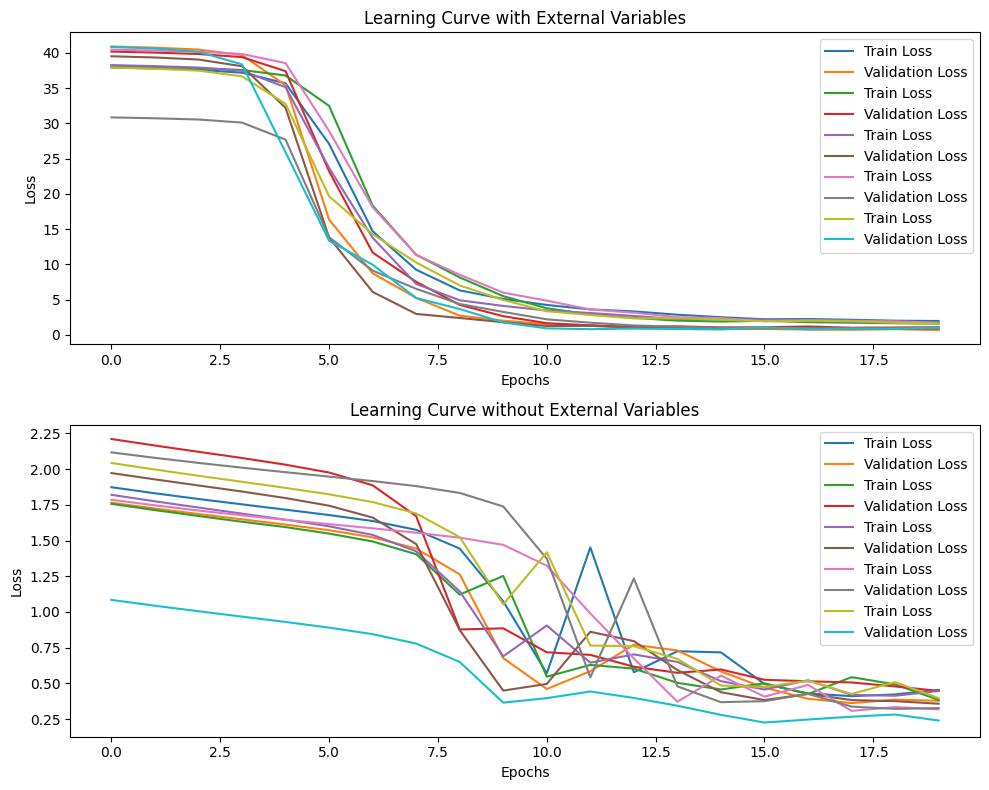

Random Forest
[[ 21   2]
 [  0 211]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        23
           1       0.99      1.00      1.00       211

    accuracy                           0.99       234
   macro avg       1.00      0.96      0.97       234
weighted avg       0.99      0.99      0.99       234

Support Vector Machine
[[ 20   3]
 [  0 211]]
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        23
           1       0.99      1.00      0.99       211

    accuracy                           0.99       234
   macro avg       0.99      0.93      0.96       234
weighted avg       0.99      0.99      0.99       234

k-Nearest Neighbors
[[ 20   3]
 [  0 211]]
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        23
           1       0.99      1.00      0.99       211

    accuracy                           0.99       234
  

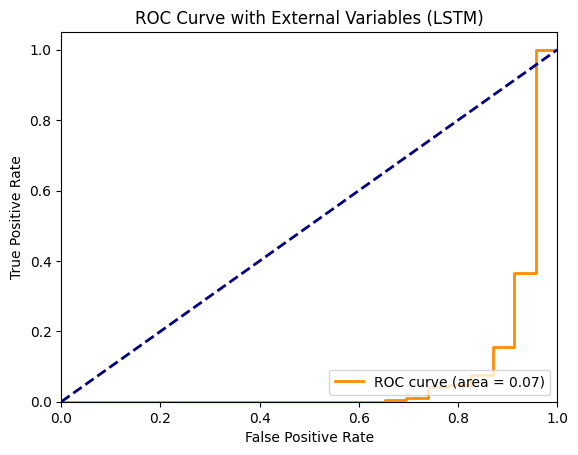

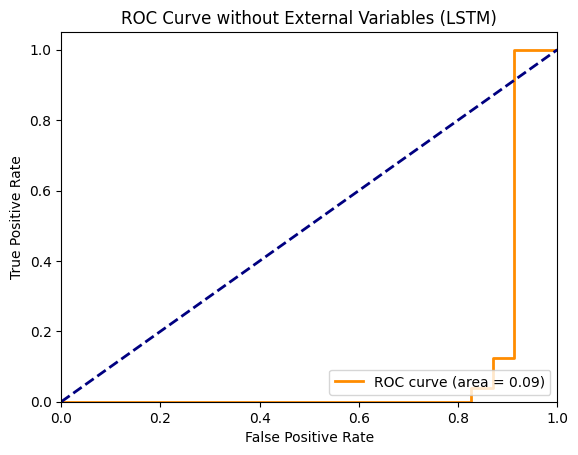

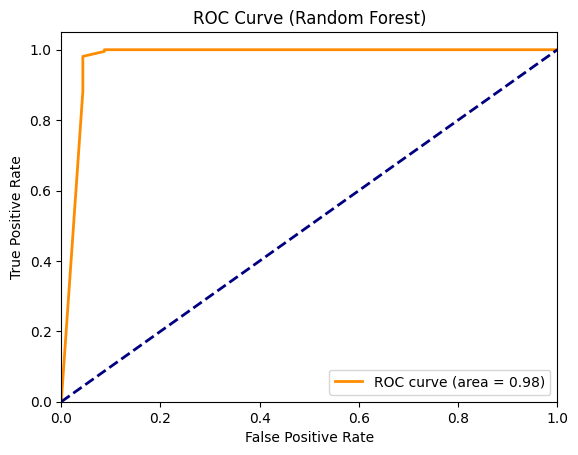

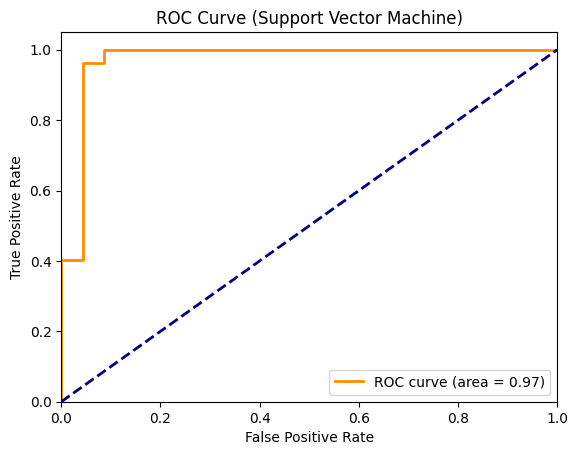

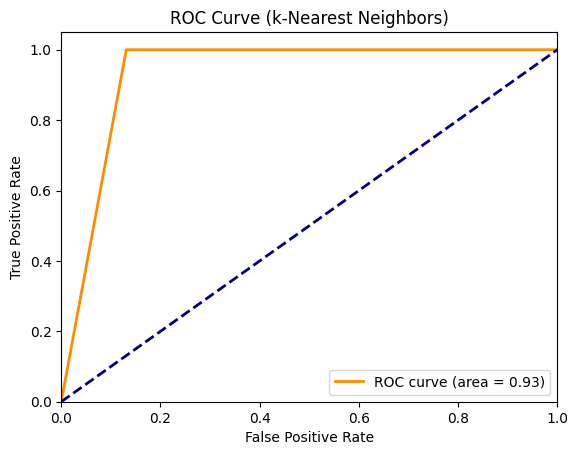

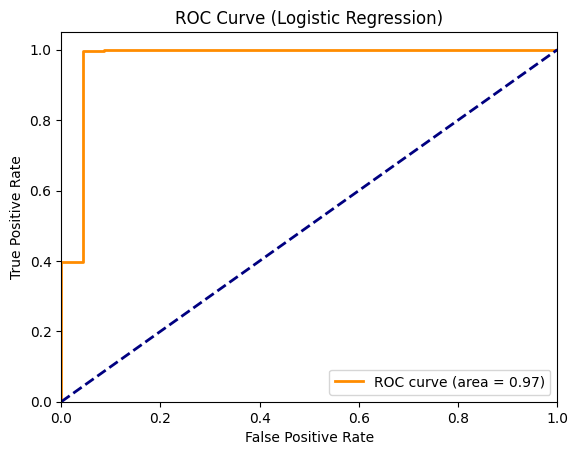

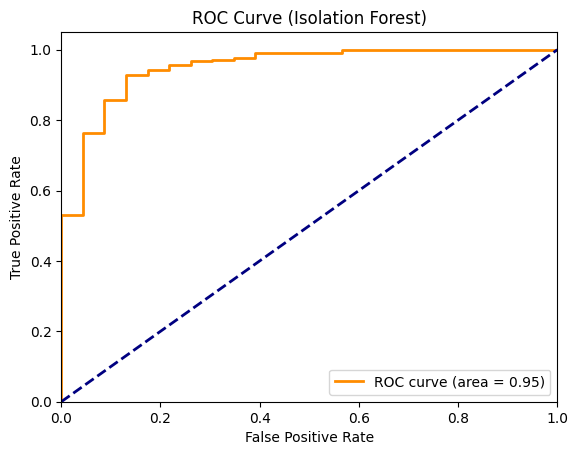

Precision t-statistic: nan, p-value: nan
Recall t-statistic: 17.908034647014002, p-value: 1.0983595100799848e-45
With External Variables (LSTM)
Best Threshold: 0.8415477131832525
Confusion Matrix:
 [[ 20   3]
 [ 19 192]]
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.87      0.65        23
           1       0.98      0.91      0.95       211

    accuracy                           0.91       234
   macro avg       0.75      0.89      0.80       234
weighted avg       0.94      0.91      0.92       234

Average Precision: 1.0
Average Recall: 1.0

Without External Variables (LSTM)
Best Threshold: 0.424936104698456
Confusion Matrix:
 [[ 19   4]
 [  0 211]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.90        23
           1       0.98      1.00      0.99       211

    accuracy                           0.98       234
   macro avg       0.99      0.9

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from scipy.stats import ttest_rel
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
file_path = 'baseline_data.csv'
df = pd.read_csv(file_path, parse_dates=['time'], index_col='time')

# Check for missing values and fill if any
df.fillna(method='ffill', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity']] = scaler.fit_transform(
    df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity']]
)

# Feature engineering
df['hour_of_day'] = df.index.hour

# Function to add synthetic anomalies
def add_synthetic_anomalies(df, anomaly_fraction=0.1, seed=42):
    np.random.seed(seed)
    df_with_anomalies = df.copy()
    num_anomalies = int(len(df) * anomaly_fraction)
    anomaly_indices = np.random.choice(df.index, num_anomalies, replace=False)
    df_with_anomalies.loc[anomaly_indices, 'device_temperature'] += np.random.normal(5, 2, size=num_anomalies)
    df_with_anomalies['label'] = 1
    df_with_anomalies.loc[anomaly_indices, 'label'] = 0
    return df_with_anomalies

# Add synthetic anomalies
df_with_anomalies = add_synthetic_anomalies(df)

# Ensure balanced train-test split
train, test = train_test_split(df_with_anomalies, test_size=0.2, stratify=df_with_anomalies['label'], random_state=42)
train, val = train_test_split(train, test_size=0.2, stratify=train['label'], random_state=42)

# Function to prepare data and train the LSTM model
def train_and_evaluate_lstm(features, train, val, test, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    precision_scores = []
    recall_scores = []
    best_thresholds = []
    history_list = []
    
    for train_index, val_index in kf.split(train):
        train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]
        X_train = train_fold[features].values.reshape((train_fold.shape[0], 1, len(features)))
        X_val = val_fold[features].values.reshape((val_fold.shape[0], 1, len(features)))
        X_test = test[features].values.reshape((test.shape[0], 1, len(features)))

        model = Sequential([
            LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            Dropout(0.2),
            LSTM(32, activation='relu', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            RepeatVector(X_train.shape[1]),
            LSTM(32, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            Dropout(0.2),
            LSTM(16, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            TimeDistributed(Dense(X_train.shape[2]))
        ])

        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse')
        history = model.fit(X_train, X_train, epochs=20, batch_size=64, validation_data=(X_val, X_val), verbose=0)
        history_list.append(history)

        X_val_pred = model.predict(X_val)
        val_mae_loss = np.mean(np.abs(X_val_pred - X_val), axis=2).flatten()
        
        thresholds = np.linspace(0, max(val_mae_loss), 100)
        precision_scores_fold = []
        recall_scores_fold = []

        for threshold in thresholds:
            y_pred = [1 if score < threshold else 0 for score in val_mae_loss]
            precision = precision_score(val_fold['label'], y_pred)
            recall = recall_score(val_fold['label'], y_pred)
            precision_scores_fold.append(precision)
            recall_scores_fold.append(recall)

        best_threshold = thresholds[np.argmax([p * r for p, r in zip(precision_scores_fold, recall_scores_fold)])]
        best_thresholds.append(best_threshold)
        precision_scores.append(max(precision_scores_fold))
        recall_scores.append(max(recall_scores_fold))
    
    best_threshold = np.mean(best_thresholds)
    X_test_pred = model.predict(X_test)
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=2).flatten()
    y_pred = [1 if score < best_threshold else 0 for score in test_mae_loss]

    cm = confusion_matrix(test['label'], y_pred)
    report = classification_report(test['label'], y_pred)

    return best_threshold, cm, report, np.mean(precision_scores), np.mean(recall_scores), test_mae_loss, test['label'].values, history_list

# Train and evaluate the LSTM model with external variables
features_with_external = ['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity', 'hour_of_day']
best_threshold_with_external, cm_with_external, report_with_external, avg_precision_with_external, avg_recall_with_external, test_mae_loss_with_external, test_labels_with_external, history_list_with_external = train_and_evaluate_lstm(features_with_external, train, val, test)

# Train and evaluate the LSTM model without external variables
features_without_external = ['device_temperature', 'device_humidity']
best_threshold_without_external, cm_without_external, report_without_external, avg_precision_without_external, avg_recall_without_external, test_mae_loss_without_external, test_labels_without_external, history_list_without_external = train_and_evaluate_lstm(features_without_external, train, val, test)

# Plot Learning Curves
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
for history in history_list_with_external:
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve with External Variables')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
for history in history_list_without_external:
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve without External Variables')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Traditional Machine Learning Models

# Prepare data
X = df_with_anomalies[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity', 'hour_of_day']]
y = df_with_anomalies['label']
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to train and evaluate traditional ML models
def evaluate_ml_model(model, model_name):
    model.fit(X_train_ml, y_train_ml)
    y_pred = model.predict(X_test_ml)
    print(model_name)
    print(confusion_matrix(y_test_ml, y_pred))
    print(classification_report(y_test_ml, y_pred))
    return y_pred

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pred = evaluate_ml_model(rf, "Random Forest")

# Support Vector Machine
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm_pred = evaluate_ml_model(svm, "Support Vector Machine")

# k-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn_pred = evaluate_ml_model(knn, "k-Nearest Neighbors")

# Logistic Regression
lr = LogisticRegression(random_state=42)
lr_pred = evaluate_ml_model(lr, "Logistic Regression")

# Isolation Forest (for anomaly detection)
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_train_ml)
iso_forest_pred = iso_forest.predict(X_test_ml)
iso_forest_pred = np.where(iso_forest_pred == 1, 0, 1)  # Convert -1 to 1 for anomalies
print("Isolation Forest")
print(confusion_matrix(y_test_ml, iso_forest_pred))
print(classification_report(y_test_ml, iso_forest_pred))

# Plot ROC Curves
def plot_roc_curve(y_true, y_pred, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(test_labels_with_external, test_mae_loss_with_external, "ROC Curve with External Variables (LSTM)")
plot_roc_curve(test_labels_without_external, test_mae_loss_without_external, "ROC Curve without External Variables (LSTM)")

# For traditional ML models
plot_roc_curve(y_test_ml, rf.predict_proba(X_test_ml)[:, 1], "ROC Curve (Random Forest)")
plot_roc_curve(y_test_ml, svm.decision_function(X_test_ml), "ROC Curve (Support Vector Machine)")
plot_roc_curve(y_test_ml, knn.predict_proba(X_test_ml)[:, 1], "ROC Curve (k-Nearest Neighbors)")
plot_roc_curve(y_test_ml, lr.predict_proba(X_test_ml)[:, 1], "ROC Curve (Logistic Regression)")
iso_forest_scores = iso_forest.decision_function(X_test_ml)
plot_roc_curve(y_test_ml, iso_forest_scores, "ROC Curve (Isolation Forest)")

# Statistical significance test
t_stat_precision, p_value_precision = ttest_rel(test_labels_with_external, test_labels_without_external)
t_stat_recall, p_value_recall = ttest_rel(test_mae_loss_with_external, test_mae_loss_without_external)
print(f"Precision t-statistic: {t_stat_precision}, p-value: {p_value_precision}")
print(f"Recall t-statistic: {t_stat_recall}, p-value: {p_value_recall}")

# Print results
print("With External Variables (LSTM)")
print("Best Threshold:", best_threshold_with_external)
print("Confusion Matrix:\n", cm_with_external)
print("Classification Report:\n", report_with_external)
print("Average Precision:", avg_precision_with_external)
print("Average Recall:", avg_recall_with_external)

print("\nWithout External Variables (LSTM)")
print("Best Threshold:", best_threshold_without_external)
print("Confusion Matrix:\n", cm_without_external)
print("Classification Report:\n", report_without_external)
print("Average Precision:", avg_precision_without_external)
print("Average Recall:", avg_recall_without_external)


Epoch 1/20
12/12 [==============================] - 2s 21ms/step - loss: 0.8836 - val_loss: 0.9391
Epoch 2/20
12/12 [==============================] - 0s 3ms/step - loss: 0.8738 - val_loss: 0.9285
Epoch 3/20
12/12 [==============================] - 0s 3ms/step - loss: 0.8636 - val_loss: 0.9172
Epoch 4/20
12/12 [==============================] - 0s 3ms/step - loss: 0.8523 - val_loss: 0.9050
Epoch 5/20
12/12 [==============================] - 0s 3ms/step - loss: 0.8400 - val_loss: 0.8905
Epoch 6/20
12/12 [==============================] - 0s 3ms/step - loss: 0.8251 - val_loss: 0.8718
Epoch 7/20
12/12 [==============================] - 0s 3ms/step - loss: 0.8038 - val_loss: 0.8430
Epoch 8/20
12/12 [==============================] - 0s 3ms/step - loss: 0.7686 - val_loss: 0.7852
Epoch 9/20
12/12 [==============================] - 0s 3ms/step - loss: 0.6826 - val_loss: 0.6315
Epoch 10/20
12/12 [==============================] - 0s 3ms/step - loss: 0.5114 - val_loss: 0.5564
Epoch 11/20
12/12 

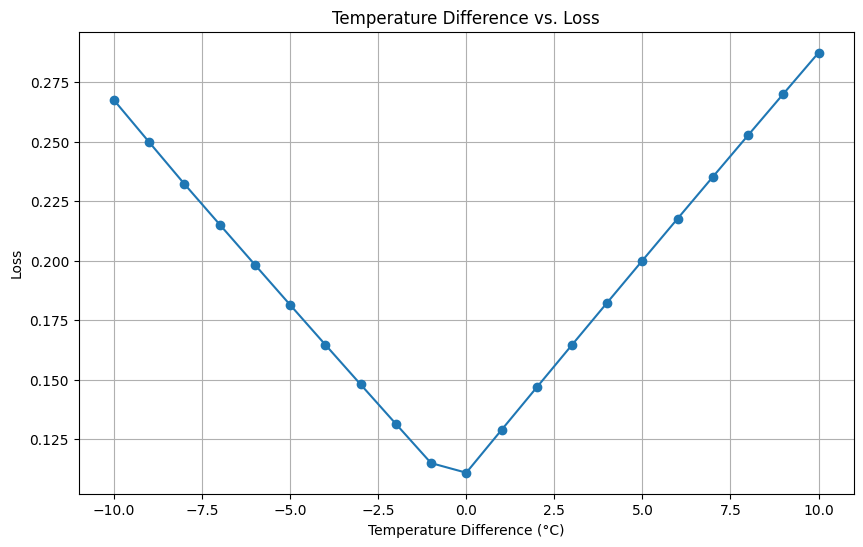

With External Variables
Best Threshold (based on training): 0.22377424340096108
Confusion Matrix:
 [[212   0]
 [  1  21]]
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       212
          -1       1.00      0.95      0.98        22

    accuracy                           1.00       234
   macro avg       1.00      0.98      0.99       234
weighted avg       1.00      1.00      1.00       234

MSE: 0.017094017094017096


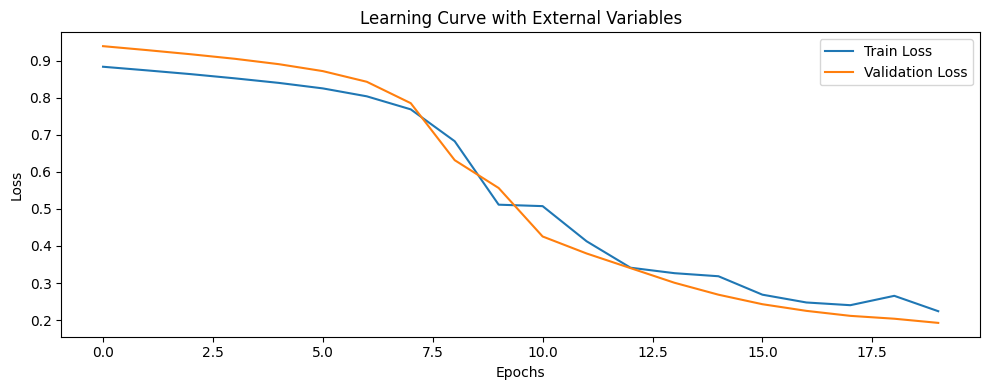

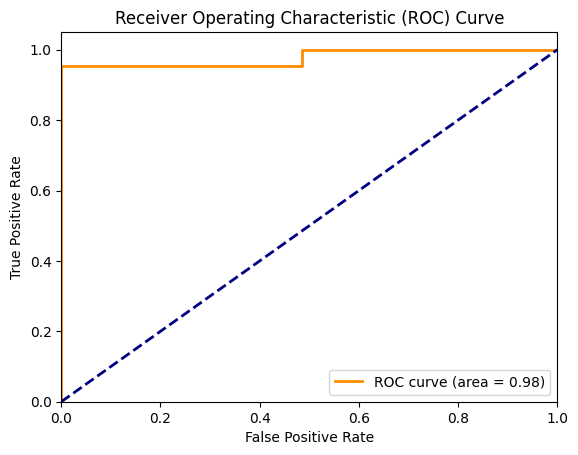

AUC: 0.9779159519725558


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, mean_squared_error, roc_curve, auc
import tensorflow as tf
import joblib

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
file_path = 'baseline_data.csv'
df = pd.read_csv(file_path, parse_dates=['time'], index_col='time')

# Feature engineering
df['hour_of_day'] = df.index.hour

# Check for missing values and fill if any
df.fillna(method='ffill', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity', 'hour_of_day']] = scaler.fit_transform(
    df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity', 'hour_of_day']]
)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Add temp_diff and humidity_diff columns for analysis
df['temp_diff'] = df['device_temperature'] - df['climate_temperature']
df['humidity_diff'] = df['device_humidity'] - df['climate_humidity']

# Function to add synthetic anomalies
def add_synthetic_anomalies(df, anomaly_fraction=0.1, seed=42):
    np.random.seed(seed)
    df_with_anomalies = df.copy()
    num_anomalies = int(len(df) * anomaly_fraction)
    anomaly_indices = np.random.choice(df.index, num_anomalies, replace=False)
    df_with_anomalies.loc[anomaly_indices, 'device_temperature'] += np.random.normal(5, 2, size=num_anomalies)
    df_with_anomalies['label'] = 1
    df_with_anomalies.loc[anomaly_indices, 'label'] = -1
    return df_with_anomalies

# Add synthetic anomalies
df_with_anomalies = add_synthetic_anomalies(df)

# Split the data
train_size = int(len(df_with_anomalies) * 0.8)
train, test = np.split(df_with_anomalies, [train_size])
val_size = int(len(train) * 0.2)
train, val = np.split(train, [len(train) - val_size])

# Function to prepare data and train the model
def train_and_save_model(features, train, val, test):
    X_train = train[features].values.reshape((train.shape[0], 1, len(features)))
    X_val = val[features].values.reshape((val.shape[0], 1, len(features)))
    X_test = test[features].values.reshape((test.shape[0], 1, len(features)))

    model = Sequential([
        LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(32, activation='relu', return_sequences=False),
        RepeatVector(X_train.shape[1]),
        LSTM(32, activation='relu', return_sequences=True),
        Dropout(0.2),
        LSTM(16, activation='relu', return_sequences=True),
        TimeDistributed(Dense(X_train.shape[2]))
    ])

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, X_train, epochs=20, batch_size=64, validation_data=(X_val, X_val), callbacks=[early_stopping])

    # Save the model
    model.save('lstm_model_with_external_variables.h5')

    X_test_pred = model.predict(X_test)
    test_mse_loss = np.mean(np.square(X_test_pred - X_test), axis=2).flatten()

    # Save the test_mse_loss and best_threshold for deployment
    joblib.dump((test_mse_loss, test['label'].values), 'test_mse_loss_and_labels.pkl')

    # Determine the threshold
    thresholds = np.linspace(0, max(test_mse_loss), 100)
    best_threshold = thresholds[np.argmax([precision_score(test['label'], [1 if score < threshold else -1 for score in test_mse_loss], pos_label=-1) *
                                            recall_score(test['label'], [1 if score < threshold else -1 for score in test_mse_loss], pos_label=-1) for threshold in thresholds])]

    # Save the threshold
    joblib.dump(best_threshold, 'best_threshold.pkl')

    y_pred = [1 if score < best_threshold else -1 for score in test_mse_loss]
    cm = confusion_matrix(test['label'], y_pred, labels=[1, -1])
    report = classification_report(test['label'], y_pred, labels=[1, -1])

    # Print the temperature difference and whether it's labeled as an anomaly
    for i, score in enumerate(test_mse_loss):
        temp_diff = test.iloc[i]['temp_diff']
        is_anomaly = 'Yes' if score > best_threshold else 'No'
        print(f"Temperature Difference: {temp_diff}, Loss: {score}, Anomaly: {is_anomaly}")

    # Calculate MSE
    mse = mean_squared_error(test['label'], y_pred)

    return model, best_threshold, cm, report, history, mse, test_mse_loss, test['label']

# Train and save the model with external variables
features_with_external = ['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity', 'hour_of_day']
model_with_external, best_threshold_with_external, cm_with_external, report_with_external, history_with_external, mse_with_external, test_mse_loss_with_external, test_labels_with_external = train_and_save_model(features_with_external, train, val, test)

# Simulate temperature data to find the relationship between temperature difference and loss
def simulate_temp_diff_and_loss(model, scaler, base_temp, temperature_diffs, device_humidity, climate_temp, climate_humidity, hour_of_day):
    results = []
    for temp_diff in temperature_diffs:
        device_temp = base_temp + temp_diff
        input_data = pd.DataFrame([[device_temp, device_humidity, climate_temp, climate_humidity, hour_of_day]], columns=features_with_external)
        input_data_scaled = scaler.transform(input_data)
        input_data_scaled = input_data_scaled.reshape((1, 1, input_data_scaled.shape[1]))

        prediction = model.predict(input_data_scaled)
        loss = np.mean(np.abs(prediction - input_data_scaled))

        results.append((temp_diff, loss))
    return results

# Define simulation parameters
base_temp = 25  # Base temperature
temperature_diffs = np.arange(-10, 11, 1)  # Simulate temperature differences from -10 to 10 degrees
device_humidity = 0.5  # Example constant humidity value (50%)
climate_temp = 25  # Example constant climate temperature
climate_humidity = 0.5  # Example constant climate humidity (50%)
hour_of_day = 12  # Example constant hour of the day

# Simulate and plot temperature difference vs loss
results = simulate_temp_diff_and_loss(model_with_external, scaler, base_temp, temperature_diffs, device_humidity, climate_temp, climate_humidity, hour_of_day)
results_df = pd.DataFrame(results, columns=['Temperature Difference', 'Loss'])

# Plot the relationship
plt.figure(figsize=(10, 6))
plt.plot(results_df['Temperature Difference'], results_df['Loss'], marker='o')
plt.title('Temperature Difference vs. Loss')
plt.xlabel('Temperature Difference (°C)')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

print(f"With External Variables")
print(f"Best Threshold (based on training): {best_threshold_with_external}")

# Save the best threshold for deployment
joblib.dump(best_threshold_with_external, 'best_threshold.pkl')

# Print results
print("Confusion Matrix:\n", cm_with_external)
print("Classification Report:\n", report_with_external)
print("MSE:", mse_with_external)

# Plot Learning Curve
plt.figure(figsize=(10, 4))
plt.plot(history_with_external.history['loss'], label='Train Loss')
plt.plot(history_with_external.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve with External Variables')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(test_labels_with_external, test_mse_loss_with_external, pos_label=-1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc}")
